<a href="https://colab.research.google.com/github/sijia1120/Advances-in-Financial-Machine-Learning/blob/master/ViT_Replicate_Learn_From_Video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch Paper Replicating (Building a Vision Transformer with PyTorch)

In [ ]:
import torch
import torchvision

In [ ]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.5.1+cu121
torchvision version: 0.20.1+cu121


In [ ]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4356, done.
remote: Counting objects: 100% (185/185), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 4356 (delta 154), reused 119 (delta 119), pack-reused 4171 (from 3)
Receiving objects: 100% (4356/4356), 654.37 MiB | 23.88 MiB/s, done.
Resolving deltas: 100% (2583/2583), done.
Updating files: 100% (248/248), done.


In [ ]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Get the Data

In [ ]:
# Download the pizza, steak, sushi images from Github
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [ ]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

## Preprocess data

step 1: Turn images into tensors using same code as PyTorch Paper Replicating section 2.1 and 2.2


In [ ]:
# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [ ]:
# Set the batch size
BATCH_SIZE = 32

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir = train_dir,
    test_dir = test_dir,
    transform = manual_transforms,
    batch_size = BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7d85b8280bb0>,
 ['pizza', 'steak', 'sushi'])

In [ ]:
# Get a batch of image
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
print(image_batch.shape, label_batch.shape)

image, label = image_batch[0], label_batch[0]
image.shape, label

torch.Size([32, 3, 224, 224]) torch.Size([32])


(torch.Size([3, 224, 224]), tensor(1))

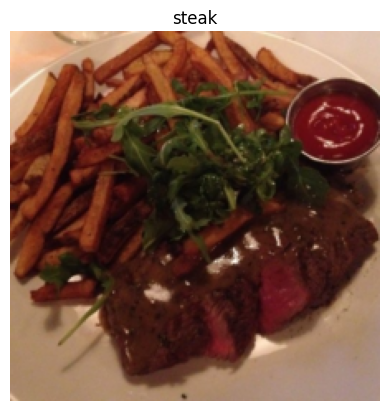

In [ ]:
# Plot image with matplotlib
plt.imshow(image.permute(1,2,0)) # Rearrange image dimensions to suit matplotlib
plt.title(class_names[label])
plt.axis(False);

# 1. Replicate the ViT architecture we created with in-built "PyTorch transformer Layers"

- You'll want to look into replicating our `TransformerEncoderBlock()` class with `torch.nn.Transformer()` (these contain the same layers as our custom blocks)
- You can stack 'torch.nn.TransformerEncoderLayer()''s on top of each other.




Needs:

1. PatchEmbedding (turn images into embeded patches)
2. Transformer Encoder layer (this is comprised of alternating MSA and MLP blocks)
3. Stack multiple transformer encoder layers on the top of each other.
4. MLP head
5. Put it all together to create ViT

### 1. Make PatchEmbedding Layer

In [ ]:
rand_image_tensor = torch.randn(size = (1, 3, 224, 224)) # (batch_size, color_channel, height_size, width_size)
# height is 224, width is 224, color channel = 3, batch size = 1
# Notice pytorch is color channel first
rand_image_tensor.shape

torch.Size([1, 3, 224, 224])

In [ ]:
# 1. Create a class which subclasses nn.Module
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.

    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """
    # 2. Initialize the class with appropriate variables
    def __init__(self,
                 in_channels:int=3,
                 patch_size:int=16, # we break the images into patches, it will be 16*16
                 embedding_dim:int=768):
        super().__init__()
        self.patch_size = patch_size

        # 3. Create a layer to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        # 4. Create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2, # only flatten the feature map dimensions into a single vector
                                  end_dim=3)

    # 5. Define the forward method
    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % self.patch_size == 0, f"Input image size must be divisible by patch size, image shape: {image_resolution}, patch size: {self.patch_size}"

        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        # 6. Make sure the output shape has the right order
        return x_flattened.permute(0, 2, 1) # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]

In [ ]:
patch_embedding = PatchEmbedding(patch_size = 16)
embedding_output = patch_embedding(rand_image_tensor)
print(f"Input shape: {rand_image_tensor.shape}")
print(f"Output shape: {embedding_output.shape} -> (batch_size, num_patches, embedding_dim)")

Input shape: torch.Size([1, 3, 224, 224])
Output shape: torch.Size([1, 196, 768]) -> (batch_size, num_patches, embedding_dim)


### 2. TransformerEncoderLayer

Can build a Transformer Encoder layer with https://pytorch.org/docs/stable/nn.html#transformer-layers

Link to Pytorch Encoder Layer:
 https://pytorch.org/docs/stable/nn.html#transformer-layers


 - TransformerEncoderLayer is made up of self-attention and feedforward network
 - In the orginal paper, the MLP only include two layers with a GELU non-linearity

In [ ]:
transformer_encoder_layer = nn.TransformerEncoderLayer(
    d_model=768, # from original paper Table 1,
    nhead=12, # number of head
    dim_feedforward = 3072,
    dropout = 0.1,
    activation = 'gelu',
    batch_first = True,
    norm_first = True,
    )
transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

1. `norm_first: ` layer norm is done prior to attention and feedforward operations, respectively. Otherwise it's done after.

2. `Dropout`: Notice that `dropout` is applied after every dense layer except for the kqv-projections and directly after adding positional- to patch embedding

In [ ]:
patch_embedding = PatchEmbedding(patch_size = 16)
patch_embedding_output = patch_embedding(rand_image_tensor)
print(f"Input Shape: {rand_image_tensor.shape}")
print(f"Output Shape: {patch_embedding_output.shape}")

Input Shape: torch.Size([1, 3, 224, 224])
Output Shape: torch.Size([1, 196, 768])


In the output shape, 196 is the number of the total patches (16 $ \times $ 16) and the 768 is the again from Table 1.

In [ ]:
from torchinfo import summary

summary(model = transformer_encoder_layer,
        input_size = (1, 196, 768))

Layer (type:depth-idx)                   Output Shape              Param #
TransformerEncoderLayer                  [1, 196, 768]             --
├─LayerNorm: 1-1                         [1, 196, 768]             1,536
├─MultiheadAttention: 1-2                [1, 196, 768]             2,362,368
├─Dropout: 1-3                           [1, 196, 768]             --
├─LayerNorm: 1-4                         [1, 196, 768]             1,536
├─Linear: 1-5                            [1, 196, 3072]            2,362,368
├─Dropout: 1-6                           [1, 196, 3072]            --
├─Linear: 1-7                            [1, 196, 768]             2,360,064
├─Dropout: 1-8                           [1, 196, 768]             --
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 4.73
Input size (MB): 0.60
Forward/backward pass size (MB): 8.43
Params size (MB): 18.90
Estimated Total Size (MB): 27.93

### 3. Stack Transformer Encoder layers on top of each other to make the full Transformer Encoder

According to Table 1 of the ViT paper, the ViT model uses a stack of 12 Transformer Encoder layers.

We can stack transformer encoder layer on top of each other using `nn.TransformerEncoder` (TransformerEncoder is a stack of N encoder layers)

In [ ]:
transformer_encoder = nn.TransformerEncoder(
    encoder_layer = transformer_encoder_layer,
    num_layers = 12,)
transformer_encoder

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


TransformerEncoder(
  (layers): ModuleList(
    (0-11): 12 x TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
      )
      (linear1): Linear(in_features=768, out_features=3072, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=3072, out_features=768, bias=True)
      (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
    )
  )
)

In [ ]:
#summary(model = transformer_encoder,
#        input_size = patch_embedding_output.shape)

### 5. Put it all together and create ViT


We are skipping step 4, so that can be incorporated the into the overall ViT architecture.

# 2. Turn the custom ViT architecture we created into a Python script, for example `vit.py`


- You should be able to import an entire ViT model using something like `from viy import ViT`

In [ ]:
class ViT(nn.Module):
  def __init__(self,
               num_classes = 1000,
               img_size = 224, # Training_resolution is 224 (from Table 3)
               patch_size = 16,
               num_channels = 3,
               embedding_dim = 768, # From Table 1
               dropout = 0.1,
               mlp_size = 3072, # From Table 1
               num_transformer_layer = 12,
               num_heads = 12,):
    super().__init__()

    # Assert image size us divisible by patch size
    assert img_size % patch_size == 0, "Image size must be divisible by patch size. "

    # 1. Create Patch Embedding
    self.patch_embedding = PatchEmbedding(in_channels = num_channels,
                                          patch_size = patch_size,
                                          embedding_dim = embedding_dim)

    # 2. Create class token
    self.class_token = nn.Parameter(torch.randn(1,1, embedding_dim), requires_grad=True)

    # 3. Create Positional Embedding
    num_patches = (img_size // patch_size) ** 2 # N = HW/P^2
    self.positional_embedding = nn.Parameter(torch.randn(1, num_patches+1, embedding_dim))

    # 4. Create patch + positional embedding dropout
    self.embedding_dropout = nn.Dropout(p= dropout)

    # 5. Create Transformer Encoder layer (single)
    self.transformer_encoder_layer = nn.TransformerEncoderLayer(d_model = embedding_dim,
                                                                nhead = num_heads,
                                                                dim_feedforward = mlp_size,
                                                                activation = 'gelu',
                                                                batch_first = True,
                                                                norm_first = True)
    # 6. Create stack Transformer Encoder layers
    self.transformer_encoder = nn.TransformerEncoder(encoder_layer = self.transformer_encoder_layer,
                                                     num_layers = 12)

    # 7. Create MLP head
    self.mlp_head = nn.Sequential(
        nn.LayerNorm(normalized_shape=embedding_dim),  # Pass the embedding_dim as normalized_shape,
        #From equation [4]
        nn.Linear(in_features = embedding_dim, out_features = num_classes
    ))

  def forward(self, x):
    # Get some dimension from X
    # Assume the demo_img = torch.randn(1,3,224,224)
    batch_size = x.shape[0]

    # Create the patch embedding
    print(f"1. The shape of input before embedding: {x.shape}")
    x = self.patch_embedding(x)
    print(f"2. The shape of after embedding: {x.shape}")

    # First, expand the class token across the batch size
    class_token = self.class_token.expand(batch_size, -1,-1) # -1 means infer the dimension

    # Prepend the class token to the patch embedding
    x = torch.cat((class_token, x), dim = 1)
    print(f"3. The shape of after embedding + classification token: {x.shape}")

    # Add the positional embedding to patch embedding with class token
    x = self.positional_embedding + x
    print(x.shape)

    # Dropout on patch + positional embedding
    x = self.embedding_dropout(x)

    # Pass embedding through Transformer Encoder stack
    x = self.transformer_encoder(x)

    # Pass 0th index of x through MLP head
    x = self.mlp_head(x)
    return x



In [ ]:
# Trying it ...
demo_img = torch.randn(32,3,224,224)

vit = ViT()
vit(demo_img).shape

1. The shape of input before embedding: torch.Size([32, 3, 224, 224])
2. The shape of after embedding: torch.Size([32, 196, 768])
3. The shape of after embedding + classification token: torch.Size([32, 197, 768])
torch.Size([32, 197, 768])


torch.Size([32, 197, 1000])

In [ ]:
patch_size = 16
img_size = 224
embedding_dim = 768
num_patches = (img_size // patch_size) ** 2
positional_embedding = nn.Parameter(torch.randn(1, num_patches+1, embedding_dim))
positional_embedding.shape

torch.Size([1, 197, 768])

In [ ]:
batch_size = 32
embedding_dim = 768
class_token = nn.Parameter(torch.randn(1,1, embedding_dim), requires_grad=True)
print(class_token.expand(batch_size,-1,-1).shape) # '-1' means to infer the dimenion
print(class_token.shape)



torch.Size([32, 1, 768])
torch.Size([1, 1, 768])


---

In [ ]:
# Create ViT feature extractor model
import torchvision

# Download pre-trained ViT weights and models
vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # "DEFAULT" means best available
pretrained_vit = torchvision.models.vit_b_16(weights = vit_weights)

# Freeze all layers in pre-trained ViT model
for params in pretrained_vit.parameters():
  params.requires_grad = False

In [ ]:
# Update the pre-trained ViT head
embedding_dim = 768
class_names = ["pizza1", "pizza2", "pizza3"]
set_seeds() # Set the GPU and Non_GPU seed

# Update the Pre-trained ViT head
pretrained_vit.heads = nn.Sequential(
    nn.LayerNorm(normalized_shape = embedding_dim),
    nn.Linear(in_features = embedding_dim, out_features = len(class_names)))

In [ ]:
# Get a summary
#summary(model = pretrained_vit,
#        input_size = (1,3,224,224),
#        col_names = ['input_size', 'output_size', 'num_params', 'trainable'],
#        #col_width =20,
#        #row_setting=["var_names"]
#)

In [ ]:
# Get 20% of the data

# Download 10 percent and 20 percent training data (if necessary)
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

# Setup train and test directories
train_dir_20_percent = data_20_percent_path / "train"
#test_dir_20_percent  = data_20_percent_path / "test"
# don't need 20% test data as the model in 07. PyTorch Experiment Tracking section 7.3 tests on
# the 10% dataset not the 20%

# Preprocess the data
vit_transforms = vit_weights.transforms() # Get transforms from vit_weights

# Create the dataloader
train_dataloader_20_percent, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir = train_dir_20_percent,
    test_dir = test_dir, # use 10% data for testing
    batch_size = 1024, # here we choose a large dataset
    transform = vit_transforms,
)

[INFO] Did not find data/pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


In [ ]:
print(len(train_dataloader), len(train_dataloader_20_percent), len(test_dataloader))

8 1 1


In [ ]:
# Train a pretrained ViT feature extractor
from going_modular.going_modular import engine


# Create optimizer and loss function
optimizer =  torch.optim.Adam(params = pretrained_vit.parameters(), lr= 1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pre-trained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model = pretrained_vit,
                                      train_dataloader = train_dataloader_20_percent,
                                      test_dataloader = test_dataloader,
                                      optimizer =  optimizer,
                                      loss_fn = loss_fn,
                                      epochs = 10,
                                      device = device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.2156 | train_acc: 0.2333 | test_loss: 1.0258 | test_acc: 0.4933
Epoch: 2 | train_loss: 0.9635 | train_acc: 0.5222 | test_loss: 0.8168 | test_acc: 0.6267
Epoch: 3 | train_loss: 0.7688 | train_acc: 0.7267 | test_loss: 0.6602 | test_acc: 0.7067
Epoch: 4 | train_loss: 0.6219 | train_acc: 0.8178 | test_loss: 0.5427 | test_acc: 0.8000
Epoch: 5 | train_loss: 0.5116 | train_acc: 0.8711 | test_loss: 0.4539 | test_acc: 0.8800
Epoch: 6 | train_loss: 0.4290 | train_acc: 0.8889 | test_loss: 0.3868 | test_acc: 0.8933
Epoch: 7 | train_loss: 0.3669 | train_acc: 0.9089 | test_loss: 0.3359 | test_acc: 0.9067
Epoch: 8 | train_loss: 0.3201 | train_acc: 0.9133 | test_loss: 0.2973 | test_acc: 0.9067
Epoch: 9 | train_loss: 0.2843 | train_acc: 0.9178 | test_loss: 0.2679 | test_acc: 0.9200
Epoch: 10 | train_loss: 0.2566 | train_acc: 0.9244 | test_loss: 0.2454 | test_acc: 0.9333


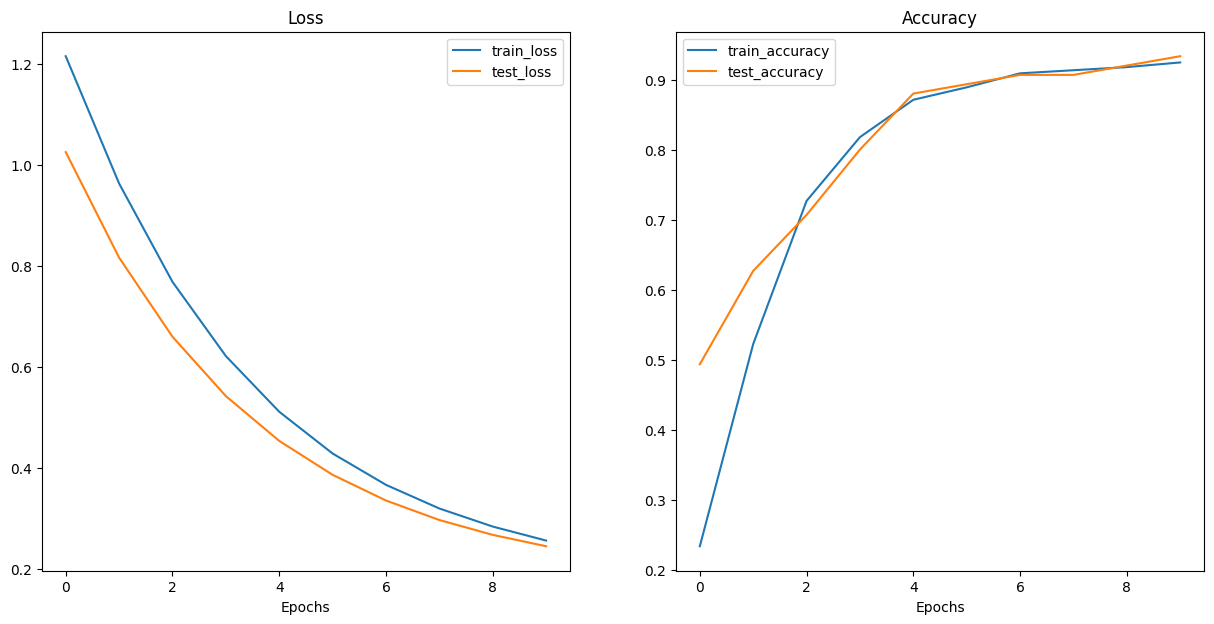

In [ ]:
# Examine Results
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

---

# 4. Try repeating the steps from excercise 3

but this time use the 'ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1' pretrained weights from 'torchvision.models.vit_b_16()'


- Note: ViT pretrained with SWAG weights has a minimum input image size of (384, 384), though this is accessble

In [ ]:
# Create ViT feature extractor model
import torchvision

# Download prtrained ViT weights and model
vit_weights_swag = torchvision.models.ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1 # get SWAG weights
pretrained_vit_swag =  torchvision.models.vit_b_16(weights = vit_weights_swag)

# Freeze all layers in pretrained ViT head
for param in pretrained_vit_swag.parameters():
  param.requires_grad = False

# Update the pretrained ViT head
embedding_dim = 768 # ViT_Base
set_seeds()
pretrained_vit_swag.heads = nn.Sequential(
    nn.LayerNorm(normalized_shape = embedding_dim),
    nn.Linear(in_features = embedding_dim,
              out_features = len(class_names))
)

# Print a summary
#summary(model = pretrained_vit_swag,
#    input_size = (1,3,384,384),
#    col_names = ["input_size", "output_size", "num_params", "trainable"],
#)

Downloading: "https://download.pytorch.org/models/vit_b_16_swag-9ac1b537.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16_swag-9ac1b537.pth
100%|██████████| 331M/331M [00:07<00:00, 45.9MB/s]


In [ ]:
# Check out transformer => minimum input image size of (384,384)
vit_transforms_swag = vit_weights_swag.transforms() # get transforms from vit_weights_swag
vit_transforms_swag

ImageClassification(
    crop_size=[384]
    resize_size=[384]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [ ]:
# Create ViT feature extractor model
import torchvision

# Download prtrained ViT weights and model
vit_weights_swag = torchvision.models.ViT_B_16_Weights.IMAGENET1K_SWAG_LINEAR_V1 # get SWAG weights
pretrained_vit_swag =  torchvision.models.vit_b_16(weights = vit_weights_swag)

# Freeze all layers in pretrained ViT head
for param in pretrained_vit_swag.parameters():
  param.requires_grad = False

# Update the pretrained ViT head
embedding_dim = 768 # ViT_Base
set_seeds()
pretrained_vit_swag.heads = nn.Sequential(
    nn.LayerNorm(normalized_shape = embedding_dim),
    nn.Linear(in_features = embedding_dim,
              out_features = len(class_names))
)

# Print a summary
summary(model = pretrained_vit_swag,
    input_size = (1,3,384,384)
)

RuntimeError: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: []

---

## 5. Our custom ViT model architecture closely mimics that of the ViT paper, however, our training receipe misses a few things


- ImageNet-22k pretraning (more data)
- Learning rate warmup
- Learning rate decay
- Gradient clipping

### Get the 'moest wrong' of the predictions on the test dataset and plot 5 'most wrong images'

How to find the "most wrong" images:
- Sort the predictions by wrong prediction and then descending predicted probabilities, this will give you the wrong predictions with the highest prediction probabilities. In other words, the "Most Wrong"

---